### 문서 유사도 측정 방법 – 코사인 유사도

In [1]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [4]:
# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 
feature_vect_dense = feature_vect_simple.todense()

#첫번째 문장과 두번째 문장의 feature vector  추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
similarity_simple = cos_similarity(vect1, vect2 )
print(f'문장 1, 문장 2 Cosine 유사도: {similarity_simple:.3f}')

문장 1, 문장 2 Cosine 유사도: 0.402


In [5]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print(f'문장 1, 문장 3 Cosine 유사도: {similarity_simple:.3f}')

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print(f'문장 2, 문장 3 Cosine 유사도: {similarity_simple:.3f}')

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [8]:
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


### Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [9]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [10]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = 'OpinosisDataset1.0/topics'
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0, encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair)


호텔로 클러스터링 된 문서들의 DataFrame Index: Int64Index([1, 13, 14, 15, 20, 21, 24, 28, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')
##### 비교 기준 문서명  bathroom_bestwestern_hotel_sfo  와 타 문서 유사도######
[[1.         0.0430688  0.05221059 0.06189595 0.05846178 0.06193118
  0.03638665 0.11742762 0.38038865 0.32619948 0.51442299 0.11282857
  0.13989623 0.1386783  0.09518068 0.07049362]]


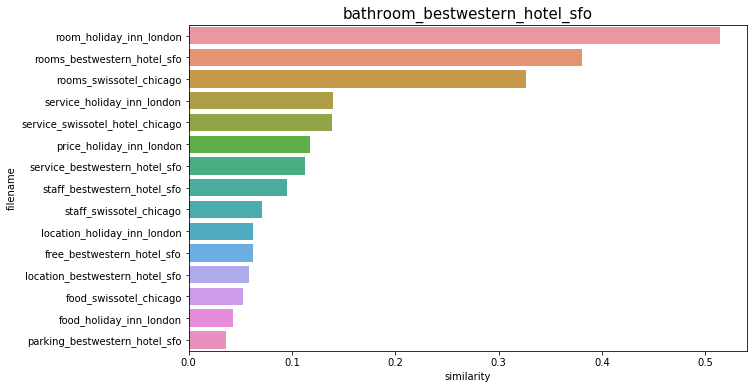

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

plt.figure(figsize=(10,6))
sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname, fontsize=15)
plt.show()